In [1]:
import random
import nltk
import re
import pandas as pd 
import pickle
import spacy
import numpy as np
import multiprocessing
from copy import copy
import tensorflow as tf
from tqdm import tqdm
import json

from nltk.corpus import opinion_lexicon
import matplotlib.pyplot as plt
from copy import copy
import seaborn as sns   
import pandas as pd 
import string
from underthesea import word_tokenize
from underthesea import pos_tag

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("opinion_lexicon")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Sentiment Analysis

## Training Phase

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Function for loading stopwords from a file
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = file.readlines()
    # Remove leading and trailing whitespaces, and newline characters
    stopwords = [word.strip() for word in stopwords]
    return stopwords

# Load Vietnamese stopwords from the file
stopwords_file = "Dataset/stopwords.txt"
vietnamese_stopwords = load_stopwords(stopwords_file)
fixed_words = ["Viện Nghiên Cứu", "học máy", "ko thoải mái", "k thoải mái", "vô trách nhiệm", "không hài lòng", "thất vọng", "không thấy đỡ", "khó mà tin tưởng",
               "khó tin tưởng", "phí thời gian", "nhăn cái mặt", "đầu đường só chợ", "vãi nồi", "không", "không trách nghiệm", "ko trách nghiệm", "không phản ánh đúng", "không giá trị"
               "khó tiếp cận", "không đảm bảo chất lượng", "ngu ngốc", 'lùa gà', 'mẹ thiên hạ', 'k hài lòng', "ko hiệu quả", "mất một đống tiền", "quá tệ",
               "vớ vẩn", "đem tiền quăng cửa sổ", "có như không", "không biết thật không nữa", "khổ_cả_đời", "mụn viêm", "không thân thiện", "không kiến thức",
               "không chuyên nghiệp", "Không giải quyết", "không đồng nhất", "chờ đợi lâu", "chờ lâu",
               "chả bao giờ", "k bao giờ", "tránh xa", "nhiều quá", "câu tương tác" , "không thấy cải thiện", "không thấy sự cải thiện",
               "gì cả", "không đáng tiền", "không đáng", "không như mong đợi", "đắt tiền", "không xứng đáng", 
               "không thấy sự thay đổi", "không cải thiện", "treo đầu dê bán thịt chó", "không tốt",
               "không đảm bảo", "không đúng", "không đáng tin cậy", "không đáng tin", "ko tư vấn", "không tư vấn", "không đáp ứng", "không trả lời", "không an toàn", "không đem lại hiệu quả", "không sự cải thiện",
               "không cải thiện", "không cải thiện", "không hết", "tốn tiền", "không hiệu quả", "không mang lại", "nói một đằng làm một nẻo",
               "không ai nghe", "không", "hên xui", "ko kết quả", "lúc nghe lúc không", "không tâm",
               "tránh xa", "kẻo lại", "k", "ko", "ko trách nghiệm", "không nhận được giá trị đáng đồng tiền", "mất lòng tin", "mất quá nhiều thời gian", "không thấy sự cải thiện",
               "không thấy hiệu quả", "quá lâu", "không thấy", "mất lịch sự", "vênh váo", "thiếu tôn trọng", "k lương tâm", "không thoải mái", "không tự tin", "giá cả", "tốn tiền", "chẳng_khác", "chả khác", "chả hiệu quả"
                "ko_thống_nhất", "ko", "mặt dày", "không trách nghiệm", "không chuyên nghiệp", "ko thân thiện", "không chất lượng", "không kiến thức", "không vệ sinh", "ko hiệu quả", "bắt máy", "không nói thẳng",
                "ko đáp ứng", "không cải thiện", "ko phản hồi", "ko uy tín", "liệu trình đắt tiền", "giá sinh viên", "trộm vía", "xinh gái"
]


import re
def preprocessing(text):
    global fixed_words
    text = str(text)
    # Lowercase
    text = text.lower()
    # Tokenization
    # Remove integers
    text = re.sub(r'\d+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text, format='text', fixed_words=fixed_words).split(' ')
    tokens = [token for token in tokens if token not in vietnamese_stopwords]
    return tokens


def remove_duplicates(my_list):
    return list(set(my_list))


In [4]:
class Ecosystem:
    def __init__(self, data_path, window_size, noun_path):
        self.data_path = data_path
        self.window_size = window_size
        self.product_sensing_values = self.read_values_from_file(noun_path)
        self.environment = []
        self.base_chromosome_key = []
        self.product_condition = []
        self.service_condition = []
        self.environment_initialization()

    def read_values_from_file(self, file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                values = file.read().splitlines()
            return values
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            return []
    
    def filer_values(self, words):
        try:
            product_contexts = []
            
            for i in range(len(words)): 
                if words[i] in self.product_sensing_values:
                    start_idx = max(0, i - self.window_size)
                    end_idx = min(len(words), i + self.window_size + 1)
                    product_contexts.extend(words[start_idx:end_idx])
                    self.base_chromosome_key.extend(words[start_idx:end_idx])
                else: 
                    self.base_chromosome_key.append(words[i])

            return {
                'product' : product_contexts,
            }
        
        except:
            return {
                'product' : [],
            }
    
    def environment_initialization(self):
        lst_env = []
        df = pd.read_csv(self.data_path, sep="\t")
        df['process_content'] = df['text'].apply(preprocessing)
        list_agents = df['process_content'].to_list()
        for agent in list_agents: 
            lst_env.append(self.filer_values(agent))

        df['label'] = df['label'].apply(int)
        self.product_condition = tf.constant(df['label'].to_list(), dtype=tf.float32)
        print(df['label'].to_list())

        self.final_base_chromosome_key = remove_duplicates([word for word in self.base_chromosome_key if word not in self.product_sensing_values])

        self.environment = {
            "product": [d["product"] for d in lst_env],
        }
    
    def environment_processing_text(self, text):
        tokens = preprocessing(text)
        processed_token = self.filer_values(tokens)
        return processed_token

In [5]:
class Individual:
    def __init__(self, mutation_rate, is_product , lower_threshold, upper_threshold):
        self.mutation_rate = mutation_rate
        self.is_product = is_product
        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold
        self.accuracy = None
        self.false_prediction_indices = None
        self.chromosome = {}

    def __add__(self, other):
        if isinstance(other, Individual):
            # Perform crossover
            crossover_point = random.randint(0, len(self.chromosome))
            child1_chromosome = {**self.chromosome, **dict(list(other.chromosome.items())[crossover_point:])}
            child2_chromosome = {**other.chromosome, **dict(list(self.chromosome.items())[crossover_point:])}

            # Apply mutation
            child1 = copy(self)
            child2 = copy(other)
            child1.chromosome = self.mutate_chromosome(child1_chromosome)
            child2.chromosome = self.mutate_chromosome(child2_chromosome)
            individuals = [other, self, child1, child2]
            return individuals
        else:
            raise TypeError("Unsupported operand type for +")

    def mutate_chromosome(self, chromosome):
        global backbone
        for _ in range(10):  # Mutate 100 random DNA keys
            dna = random.choice(list(chromosome.keys()))
            if random.random() < self.mutation_rate:
                if dna in backbone['positive']:
                    if chromosome[dna] < 0 : 
                         chromosome[dna] = random.uniform(0, 1)
                    else:
                        if random.uniform(0,1) < 0.5:
                            chromosome[dna] = random.uniform(0, chromosome[dna])
                        else:  
                            chromosome[dna] = random.uniform(chromosome[dna], 1)
                else:
                    if chromosome[dna] >=0 : 
                        chromosome[dna] = random.uniform(-1, 0)
                    else: 
                        if random.uniform(0,1) < 0.5:
                            chromosome[dna] = random.uniform(-1, chromosome[dna])
                        else:  
                            chromosome[dna] = random.uniform(chromosome[dna], 0)
        return chromosome
    
    def calculate_fitness(self, y_true, p):
        # Map the p values to the corresponding class labels
        with tf.device('/GPU:0'):
            y_true_class = tf.where(p < 0, 0,1 )

            # Convert y_true_class to integers
            y_true_class = tf.cast(y_true_class, tf.int32)

            # Assuming y_true is a TensorFlow tensor, convert it to integers
            y_true = tf.cast(y_true, tf.int32)


            accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_true_class), dtype=tf.float32))

            # Calculate indices of false predictions
            false_prediction_indices = tf.where(tf.not_equal(y_true, y_true_class))

        return accuracy, false_prediction_indices
    
    
    def compatibility(self, environment, product_condition, service_condition):
        # Calculate individual p_value
        if self.is_product:
            lst_alga = [self.calculate_alga(line) for line in environment['product']]
            p = tf.constant(lst_alga, dtype=tf.float32)

        self.accuracy, self.false_prediction_indices = self.calculate_fitness(y_true=product_condition if self.is_product else service_condition, p=p)

    def calculate_alga(self, window):
        alga_scores = np.zeros(len(window))
        for i, word in enumerate(window):
            try:
                alga_scores[i] = self.chromosome[word]
            except KeyError:
                try:
                    # alga_scores[i] = self.backup_dnas[word]
                    pass
                except KeyError:
                    # global analyser
                    # sentiment = analyser.polarity_scores(word)
                    # alga_scores[i] = sentiment['compound']
                    pass

        return np.sum(alga_scores)
    
    def chromosome_generation_pooling(self, backbone):
        self.chromosome = {}

        for key, protein_set in backbone.items(): 
            # for protein in protein_set:
            #     self.chromosome[protein] = random.uniform(-5, 5)
            if key == 'positive':
                for protein in protein_set:
                    self.chromosome[protein] = random.uniform(0, 1)
            else: 
                for protein in protein_set:
                    self.chromosome[protein] = random.uniform(-1, 0)
        return copy(self)

    def predict(self, text):
        alga = self.calculate_alga(text)
        if alga >= 0:
            return 1
        else: 
            return 0

In [6]:

physical_devices = tf.config.experimental.list_physical_devices()

# Print details of each physical device
for device in physical_devices:
    print("Device name:", device.name)
    print("Device type:", device.device_type)
    if 'GPU' in device.name:
        print("Memory details:", tf.test.gpu_device_name())
    print()


Device name: /physical_device:CPU:0
Device type: CPU

Device name: /physical_device:GPU:0
Device type: GPU
Memory details: /device:GPU:0



In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Found GPU:", gpu_devices)
else:
    print("No GPU found. TensorFlow will use CPU for computations.")

# Optionally, print GPU details
for gpu in gpu_devices:
    print("GPU details:", gpu)

# Run a simple TensorFlow operation to ensure GPU is utilized
print("Running TensorFlow operation on GPU...")
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 1.0])
    b = tf.constant([1.0, 4.0, 3.0, 2.0, 1.0])
    c = tf.multiply(a, b)

# Print result
print("Result:", c)


Found GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Running TensorFlow operation on GPU...
Result: tf.Tensor([1. 8. 9. 8. 1.], shape=(5,), dtype=float32)


In [8]:
NUM_GENERATION = 20
DATA_PATH = "Dataset/training_alga.tsv"
WINDOW_SIZE = 2 
NOUN_PATH = "Utils/final_noun.txt"
MUTATION_RATE = 0.2
POPULATION_SIZE = 500
LOWER_THRESHOLD = 0.05
UPPER_THRESHOLD = 1
IS_PRODUCT = True


In [9]:
import json
json_file_path = 'Utils/backbone.json'
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    backbone = json.load(json_file)

In [10]:
#ecosystem init
ecs = Ecosystem(data_path=DATA_PATH, window_size=WINDOW_SIZE, noun_path=NOUN_PATH)

environment = ecs.environment
product_condition = ecs.product_condition
service_condition = ecs.service_condition

[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 

In [11]:
environment

{'product': [['tiền_bạc',
   'dịch_vụ',
   'không',
   'hiệu_quả',
   'dịch_vụ',
   'không',
   'hiệu_quả',
   'thất_vọng'],
  ['chào', 'bác_sĩ'],
  [],
  ['e', 'miếng', 'nám', 'trán', 'bs', 'nám', 'trán', 'bs'],
  ['mong', 'lộc', 'bs', 'ạl'],
  ['đợi', 'lượt', 'kết_quả', 'không'],
  [],
  ['công_nghệ', 'nâng', 'trẻ', 'trẻ', 'hóa', 'fda', 'chứng_nhận', 'an_toàn'],
  ['trải_nghiệm', 'tệ', 'không', 'tệ', 'không', 'hiệu_quả'],
  ['trình',
   'trị',
   'mụn',
   'hạt',
   'trắng',
   'laser',
   'ko',
   'kết_quả',
   'một_tí',
   'gì_cả'],
  [],
  [],
  ['mẹ_con_em', 'chờ', 'quà', 'hôm'],
  [],
  [],
  [],
  [],
  ['thất_vọng',
   'tay_nghề',
   'mấy',
   'xăm',
   'đàng',
   'ngã',
   'tư_vấn',
   'không',
   'ôn'],
  ['bs', 'đi', 'nước_ngoài'],
  ['không', 'sẳn_tiện', 'da', 'tiêm', 'đc'],
  [],
  [],
  [],
  [],
  [],
  ['chân_mày', 'lệch', 'nhân_viên', 'xấc', 'xược'],
  ['nhân_viên',
   'nói_chuyện',
   'không',
   'nói_chuyện',
   'không',
   'thái_độ',
   'giang_hồ',
   'xấu'],
  ['v

In [12]:
history = []

# Define the number of threads to use# Define a function to generate an individual
def generate_individual(j, backbone, environment, service_condition, product_condition):
    indi = Individual(mutation_rate=0.2, is_product=True, lower_threshold=LOWER_THRESHOLD, upper_threshold=UPPER_THRESHOLD).chromosome_generation_pooling(backbone=backbone)
    indi.compatibility(environment=environment, service_condition=service_condition, product_condition=product_condition)
    return indi

# Create an empty population list
population = []

# Generate individuals in a loop
for j in tqdm(range(POPULATION_SIZE), desc="Generating Individuals", unit="individual"):
    indi = generate_individual(j, backbone, environment, service_condition, product_condition)
    population.append(indi)

history.append(population)


Generating Individuals:   0%|          | 2/500 [00:00<00:25, 19.51individual/s]

Generating Individuals: 100%|██████████| 500/500 [00:05<00:00, 85.13individual/s] 


In [13]:
history[0][0].accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.95103735>

In [14]:
len(history)

1

In [15]:

def generate_new_generation(lst_individual):
    # Sort the list based on fitness in ascending order
    sorted_individuals = sorted(lst_individual, key=lambda x: x.accuracy)
    # Take the two individuals with the lowest fitness
    parent1, parent2 = sorted_individuals[-2:]
    # Perform crossover to generate a new individual
    generation = parent1 + parent2
    generation[2].compatibility(environment=environment, service_condition=service_condition, product_condition=product_condition)
    generation[3].compatibility(environment=environment, service_condition=service_condition, product_condition=product_condition)
    sorted_individuals = sorted(generation, key=lambda x: x.accuracy)
    return sorted_individuals[-2:]

In [16]:
# At this point, the 'population' list will contain the generated individuals
for _ in range(2*NUM_GENERATION-1):
    population = []
    print(_)
    while len(population) <POPULATION_SIZE:
        population_subset = random.sample(history[-1], 10)
        population += generate_new_generation(population_subset)
    history.append(population)
    higest_accuracy = max(individual.accuracy for individual in population)
    print(higest_accuracy)

0
tf.Tensor(0.9618257, shape=(), dtype=float32)
1
tf.Tensor(0.9618257, shape=(), dtype=float32)
2
tf.Tensor(0.96431535, shape=(), dtype=float32)
3
tf.Tensor(0.96431535, shape=(), dtype=float32)
4
tf.Tensor(0.96431535, shape=(), dtype=float32)
5
tf.Tensor(0.96514523, shape=(), dtype=float32)
6
tf.Tensor(0.9659751, shape=(), dtype=float32)
7
tf.Tensor(0.966805, shape=(), dtype=float32)
8
tf.Tensor(0.96763486, shape=(), dtype=float32)
9
tf.Tensor(0.96763486, shape=(), dtype=float32)
10
tf.Tensor(0.96763486, shape=(), dtype=float32)
11
tf.Tensor(0.96763486, shape=(), dtype=float32)
12
tf.Tensor(0.96763486, shape=(), dtype=float32)
13
tf.Tensor(0.96763486, shape=(), dtype=float32)
14
tf.Tensor(0.96763486, shape=(), dtype=float32)
15
tf.Tensor(0.96763486, shape=(), dtype=float32)
16
tf.Tensor(0.96763486, shape=(), dtype=float32)
17
tf.Tensor(0.96763486, shape=(), dtype=float32)
18
tf.Tensor(0.96763486, shape=(), dtype=float32)
19
tf.Tensor(0.96763486, shape=(), dtype=float32)
20
tf.Tensor(0.

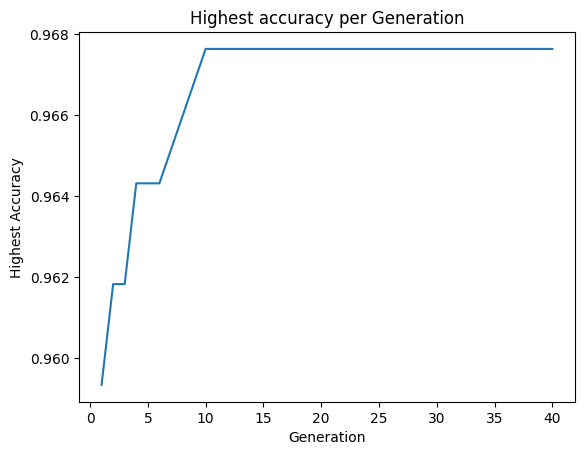

Highest Accuract IDs per Generation: [479, 235, 71, 129, 16, 13, 33, 77, 103, 81, 45, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [42]:
import matplotlib.pyplot as plt
higest_accuracy_per_gen = []
higest_accuracy_id_per_generation = []

for population in history:
    highest_accuracy_id = max(((i, ind.accuracy) for i, ind in enumerate(population)), key=lambda x: x[1])[0]
    highest_accuract = max(individual.accuracy for individual in population)
    higest_accuracy_per_gen.append(highest_accuract)
    higest_accuracy_id_per_generation.append(highest_accuracy_id)

# Plot the lowest fitness per generation
plt.plot(range(1, len(history) + 1), higest_accuracy_per_gen)
plt.title('Highest accuracy per Generation')
plt.xlabel('Generation')
plt.ylabel('Highest Accuracy')
plt.show()
print("Highest Accuract IDs per Generation:", higest_accuracy_id_per_generation)

## Tesing phase

In [18]:
history[-1][0].false_prediction_indices

<tf.Tensor: shape=(39, 1), dtype=int64, numpy=
array([[  17],
       [  19],
       [ 111],
       [ 123],
       [ 126],
       [ 131],
       [ 133],
       [ 213],
       [ 232],
       [ 240],
       [ 241],
       [ 273],
       [ 276],
       [ 300],
       [ 306],
       [ 369],
       [ 372],
       [ 374],
       [ 387],
       [ 425],
       [ 488],
       [ 502],
       [ 558],
       [ 577],
       [ 606],
       [ 670],
       [ 704],
       [ 709],
       [ 744],
       [ 770],
       [ 795],
       [ 825],
       [ 852],
       [ 902],
       [1009],
       [1019],
       [1098],
       [1143],
       [1169]], dtype=int64)>

In [19]:
environment['product'][423]

['mong',
 'quà',
 'tặng',
 'điều_trị',
 'quà',
 'tặng',
 'điều_trị',
 'nám',
 'pensilia',
 'tặng',
 'điều_trị',
 'nám',
 'pensilia',
 'điều_trị',
 'nám',
 'pensilia']

In [20]:
test_ecs = Ecosystem(data_path="Dataset/testing_alga.tsv", window_size=WINDOW_SIZE, noun_path=NOUN_PATH)

environment = test_ecs.environment

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


In [21]:
lst_new = []
for agent in environment['product']: 
    lst_new.append(history[-1][higest_accuracy_id_per_generation[-1]].predict(agent))

In [22]:
df = pd.read_csv("Dataset/testing_alga.tsv", sep=  '\t')


In [23]:
# Create a new column 'Predicted' in df and assign the predicted values
df['Predicted'] = lst_new

# Now you can compare 'Predicted' with 'Product' column
comparison_result = df['Predicted'] == df['label']

# If you want to see the rows where the prediction matches the product
matching_rows = df[comparison_result]

# If you want to see the rows where the prediction does not match the product
mismatching_rows = df[~comparison_result]

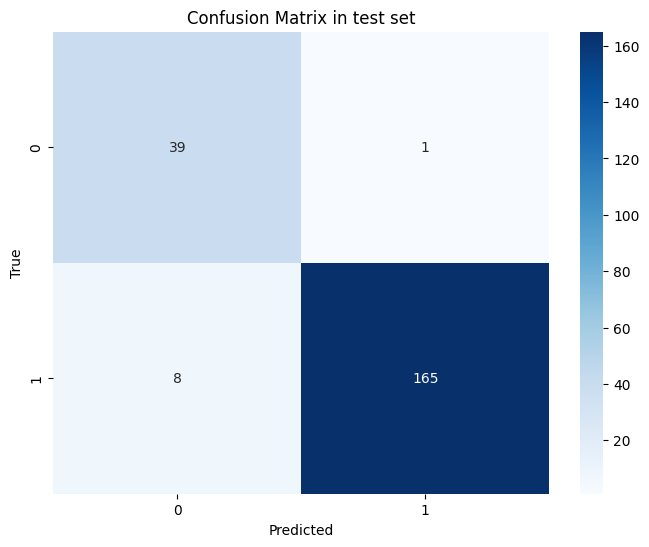

Accuracy: 0.9577
Precision: 0.9631
Recall: 0.9577
F1 Score: 0.9590


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(df['label'], df['Predicted'])
precision = precision_score(df['label'], df['Predicted'], average='weighted')
recall = recall_score(df['label'], df['Predicted'], average='weighted')
f1 = f1_score(df['label'], df['Predicted'], average='weighted')

# Confusion Matrix
conf_mat = confusion_matrix(df['label'], df['Predicted'])
labels = np.sort(df['label'].unique())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix in test set')
plt.show()

# Display metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [25]:
lst_accuracy_test = []
for i in range(len(history)):
    lst_new = []
    for agent in environment['product']: 
        lst_new.append(history[i][higest_accuracy_id_per_generation[i]].predict(agent))
        # Create a new column 'Predicted' in df and assign the predicted values
    df['Predicted'] = lst_new

    # Now you can compare 'Predicted' with 'Product' column
    comparison_result = df['Predicted'] == df['label']

    # If you want to see the rows where the prediction matches the product
    matching_rows = df[comparison_result]

    # If you want to see the rows where the prediction does not match the product
    mismatching_rows = df[~comparison_result]
    accuracy = accuracy_score(df['label'], df['Predicted'])
    lst_accuracy_test.append(accuracy)

In [26]:
lst_accuracy_train = []
for i in range(len(history)):
    lst_accuracy_train.append(history[i][higest_accuracy_id_per_generation[i]].accuracy)

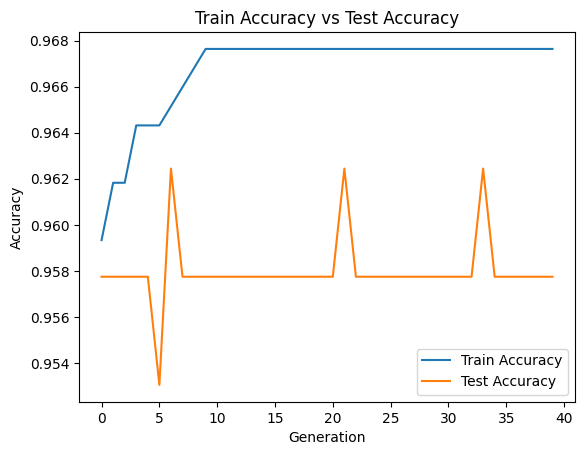

In [27]:
plt.plot(lst_accuracy_train, label='Train Accuracy')
plt.plot(lst_accuracy_test, label='Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()
plt.show()

In [28]:
a = history[i][higest_accuracy_id_per_generation[1]].chromosome

In [29]:
a

{'thơm': 0.4233199841874192,
 'xinh_gái': 0.48675417945500604,
 'xinh_đẹp': 0.6896902639989971,
 'nhì': 0.02745753711465393,
 'già': -0.6306388125601954,
 'cận': 0.18697787087052375,
 'trộm vía': 0.2849765926543763,
 'tuyệt_vời': 0.46163311647268224,
 'bần_bật': 0.18322486717501985,
 'tạm': -0.6387626618140034,
 'giá sinh viên': 0.21058540331686226,
 'đắt': -0.562341296897532,
 'chuẩn': 0.15735302802439355,
 'dễ': 0.7576460362889235,
 'đen': 0.9946255633948516,
 'chừng': 0.6959485966893861,
 'suốt': 0.13664173035285582,
 'trọn_vẹn': 0.9303324432345547,
 'thik': 0.93980319914055,
 'vui_vẻ': 0.9090555103964677,
 'tím': 0.11963151472296063,
 'tận_tình': 0.593553411752558,
 'sướng': 0.7951144850449958,
 'đẹp': 0.14650283577008383,
 'khỏe': 0.9125223602654426,
 'tiện': 0.2066624297066334,
 'mạnh_mẽ': 0.7852444542363954,
 'ngon': 0.19709137245248443,
 'tràn_đầy': 0.4414053471044932,
 'giỏi': 0.9266363565327848,
 'mau': 0.04948449299366897,
 'sạch': -0.275327421212604,
 'rẻ': 0.68793945706415

In [30]:
product_indi = history[-1][0]

In [31]:
product_indi

In [12]:
import pickle

file_path = 'Model/best_individual.pickle'

# Load the data from the pickle file
with open(file_path, 'rb') as f:
    product_indi = pickle.load(f)

# Print the loaded data
print(product_indi)


In [13]:
product_indi.chromosome

{'thơm': 0.12414781951497267,
 'xinh_gái': 0.3911866667633167,
 'xinh_đẹp': 0.6896902639989971,
 'nhì': 0.02745753711465393,
 'già': -0.6306388125601954,
 'cận': 0.18697787087052375,
 'trộm vía': 0.10775333773225615,
 'tuyệt_vời': 0.46163311647268224,
 'bần_bật': 0.7884917796612518,
 'tạm': -0.6387626618140034,
 'giá sinh viên': 0.21058540331686226,
 'đắt': -0.562341296897532,
 'chuẩn': 0.15735302802439355,
 'dễ': 0.7576460362889235,
 'đen': 0.9946255633948516,
 'chừng': 0.8105908511684393,
 'suốt': 0.13664173035285582,
 'trọn_vẹn': 0.9303324432345547,
 'thik': 0.93980319914055,
 'vui_vẻ': 0.9090555103964677,
 'tím': 0.11963151472296063,
 'tận_tình': 0.593553411752558,
 'sướng': 0.7951144850449958,
 'đẹp': 0.14650283577008383,
 'khỏe': 0.9125223602654426,
 'tiện': 0.2066624297066334,
 'mạnh_mẽ': 0.7852444542363954,
 'ngon': 0.19709137245248443,
 'tràn_đầy': 0.4414053471044932,
 'giỏi': 0.9266363565327848,
 'mau': 0.04948449299366897,
 'sạch': -0.275327421212604,
 'rẻ': 0.68793945706415

In [14]:
df = pd.DataFrame(list(product_indi.chromosome.items()), columns=['Adjective', 'Score'])

print(df)

        Adjective     Score
0            thơm  0.124148
1        xinh_gái  0.391187
2        xinh_đẹp  0.689690
3             nhì  0.027458
4             già -0.630639
..            ...       ...
351  trách_nghiệm -0.286288
352   ko_phản_hồi -0.142218
353          đừng -0.013850
354         sự_cố -0.645762
355          thừa -0.139702

[356 rows x 2 columns]


In [15]:
df.to_csv("Dataset/keywords.tsv", sep = '\t', index=False)

In [32]:
file_path = 'Model/best_individual.pickle'

# Save the data to the pickle file
with open(file_path, 'wb') as f:
    pickle.dump(product_indi, f)

print("Data saved to", file_path)

Data saved to Model/best_individual.pickle


## Chromosome Analysis

In [33]:
product_indi.chromosome

{'thơm': 0.12414781951497267,
 'xinh_gái': 0.3911866667633167,
 'xinh_đẹp': 0.6896902639989971,
 'nhì': 0.02745753711465393,
 'già': -0.6306388125601954,
 'cận': 0.18697787087052375,
 'trộm vía': 0.10775333773225615,
 'tuyệt_vời': 0.46163311647268224,
 'bần_bật': 0.7884917796612518,
 'tạm': -0.6387626618140034,
 'giá sinh viên': 0.21058540331686226,
 'đắt': -0.562341296897532,
 'chuẩn': 0.15735302802439355,
 'dễ': 0.7576460362889235,
 'đen': 0.9946255633948516,
 'chừng': 0.8105908511684393,
 'suốt': 0.13664173035285582,
 'trọn_vẹn': 0.9303324432345547,
 'thik': 0.93980319914055,
 'vui_vẻ': 0.9090555103964677,
 'tím': 0.11963151472296063,
 'tận_tình': 0.593553411752558,
 'sướng': 0.7951144850449958,
 'đẹp': 0.14650283577008383,
 'khỏe': 0.9125223602654426,
 'tiện': 0.2066624297066334,
 'mạnh_mẽ': 0.7852444542363954,
 'ngon': 0.19709137245248443,
 'tràn_đầy': 0.4414053471044932,
 'giỏi': 0.9266363565327848,
 'mau': 0.04948449299366897,
 'sạch': -0.275327421212604,
 'rẻ': 0.68793945706415

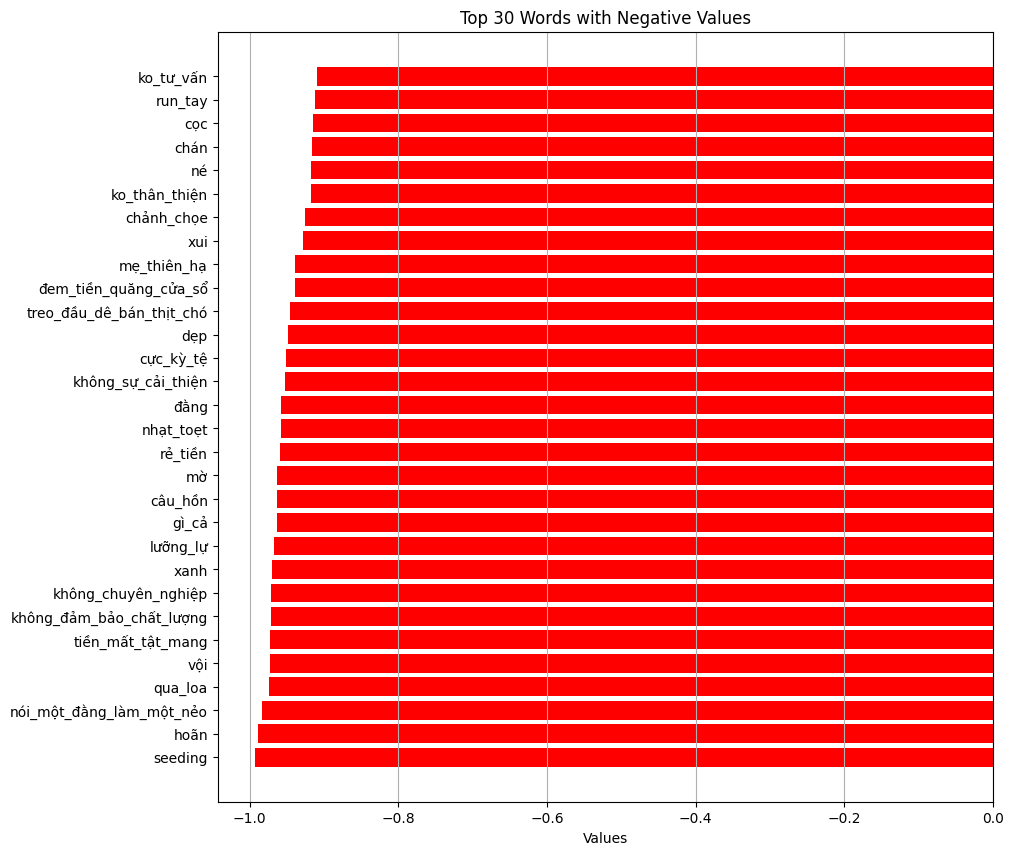

In [34]:
top_negatives = {key: value for key, value in sorted(product_indi.chromosome.items(), key=lambda item: item[1]) if value < 0}

top_30_negatives = dict(list(top_negatives.items())[:30])

# Plotting
plt.figure(figsize=(10, 10))
plt.barh(list(top_30_negatives.keys()), list(top_30_negatives.values()), color='red')
plt.xlabel('Values')
plt.title('Top 30 Words with Negative Values')
plt.grid(axis='x')
plt.show()

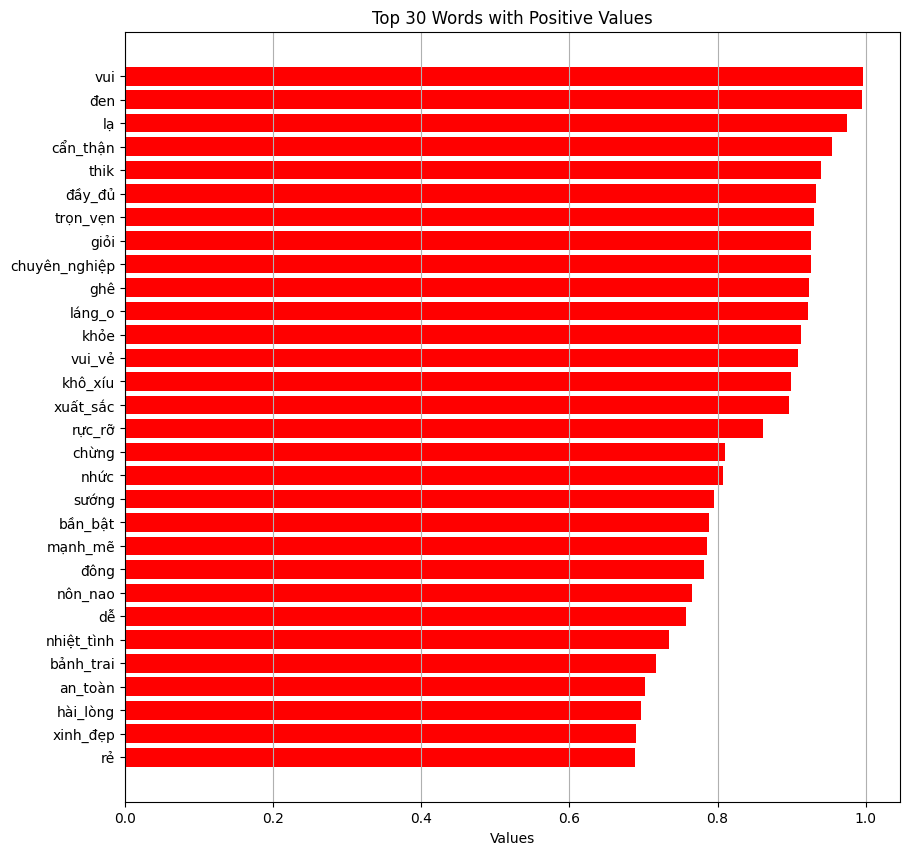

In [35]:
top_positive = {key: value for key, value in sorted(product_indi.chromosome.items(), key=lambda item: item[1]) if value > 0}

top_30_positive = dict(list(top_positive.items())[-30:])

# Plotting
plt.figure(figsize=(10, 10))
plt.barh(list(top_30_positive.keys()), list(top_30_positive.values()), color='red')
plt.xlabel('Values')
plt.title('Top 30 Words with Positive Values')
plt.grid(axis='x')
plt.show()

# Customer Complaints Analysis

# linh tinh

In [36]:
df = pd.read_csv("Dataset\df_with_label.tsv", sep='\t')

In [37]:
df.head()

,text,label
0,Dịch vụ này thật là đáng thất vọng! Đã bỏ ra s...,0
1,"Lần đầu đi cũng thấy niềm nở lắm, nhưng mà nhâ...",0
2,Mình được người quen giới thiệu đến khám tại p...,1
3,Ban đầu cũng uy tín nhưng mà giá đắt quá. Cũng...,0
4,Bác sĩ tư vấn như muốn lấy thêm tiền của khách...,0


In [38]:
lst_old = df['label'].to_list()
lst_new = []
for agent in environment['product']: 
    lst_new.append(history[-1][0].predict(agent))

In [39]:
lst = []
for i in range(len(lst_new)):
    if random.uniform(0,1) < 0.75:
        lst.append(lst_new[i])
    else: 
        lst.append(lst_old[i])

In [40]:
df['label'] = lst

ValueError: Length of values (213) does not match length of index (1418)

## Analysis

In [ ]:
df = pd.read_csv("Dataset\df_with_label.tsv", sep='\t')

In [ ]:
df['ID'] = df.index

In [ ]:
def read_values_from_file(file_path):
    try:
        with open(file_path, 'r', encoding="utf-8") as file:
            values = file.read().splitlines()
        return values
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []

In [ ]:
noun_values = read_values_from_file("Utils/final_noun.txt")
window_size = 2

In [ ]:
def extract_windows(id ,words):
    global noun_values
    global window_size
    agent_dict = { "id": id,
                  "windows" : {} }
    for i in range(len(words)): 
        if words[i] in noun_values:
            if words[i] in agent_dict["windows"].keys():
                pass
            else:
                agent_dict["windows"][words[i]] = []
            start_idx = max(0, i - window_size)
            end_idx = min(len(words), i + window_size + 1)
            for word in words[start_idx:end_idx]:
                agent_dict["windows"][words[i]].append(word)
    return agent_dict

In [ ]:
lst_agents  = []
for index, row in df.iterrows():
    lst_agents.append(extract_windows(row["ID"],row["Preprocessed_Content"]))

In [ ]:

lst_row = []
for row in lst_agents:
    flat_data = {'id': row['id']}
    for window_key, window_value in row['windows'].items():
        obj = {}
        obj['id'] = row['id']
        obj['aspect_words'] = window_key
        obj['window_values'] = window_value
        lst_row.append(obj)

In [ ]:
df = pd.DataFrame(lst_row)

In [ ]:
df.head()

,id,aspect_words,window_values
0,0,dịch_vụ,"[dịch_vụ, thất_vọng, tiền]"
1,0,trải_nghiệm,"[tiền, không, trải_nghiệm, tệ_hại, chờ_đợi_lâu]"
2,0,nhân_viên,"[tệ_hại, chờ_đợi_lâu, nhân_viên, không, chú_ý]"
3,0,khách_hàng,"[không, chú_ý, khách_hàng, lịch, thụ_động]"
4,0,lịch,"[chú_ý, khách_hàng, lịch, thụ_động, vô_cùng]"


In [ ]:
def calculate_alga_based_on_window_type(row):
    return product_indi.calculate_alga(row['window_values'])

df['calculated_alga'] = df.apply(calculate_alga_based_on_window_type, axis=1)
